In [1]:
import os
# import drjit
# gpu_num = [0, 1, 2, 3, 4] # Use "" to use the CPU
gpu_num = 1
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

from jammer.simulation_model import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [2]:
print(tf.config.list_logical_devices('GPU'))
print(tf.config.list_physical_devices('GPU'))

[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU'), LogicalDevice(name='/device:GPU:2', device_type='GPU'), LogicalDevice(name='/device:GPU:3', device_type='GPU'), LogicalDevice(name='/device:GPU:4', device_type='GPU'), LogicalDevice(name='/device:GPU:5', device_type='GPU'), LogicalDevice(name='/device:GPU:6', device_type='GPU'), LogicalDevice(name='/device:GPU:7', device_type='GPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.5677e-02 | 1.0000e+00 |      364884 |     6553600 |          640 |         640 |        17.4 |reached max iter       
   -3.667 | 3.8756e-02 | 1.0000e+00 |      253991 |     6553600 |          640 |         640 |         0.9 |reached max iter       
   -2.333 | 2.7562e-02 | 1.0000e+00 |      180628 |     6553600 |          640 |         640 |         0.9 |reached max iter       
     -1.0 | 2.0682e-02 | 1.0000e+00 |      135540 |     6553600 |          640 |         640 |         0.9 |reached max iter       
    0.333 | 1.6557e-02 | 1.0000e+00 |      108509 |     6553600 |          640 |         640 |         0.9 |reached max iter       
    1.667 | 1.3552e-02 | 1.0000e+00 |       88816 |     6553600 |          640 |     

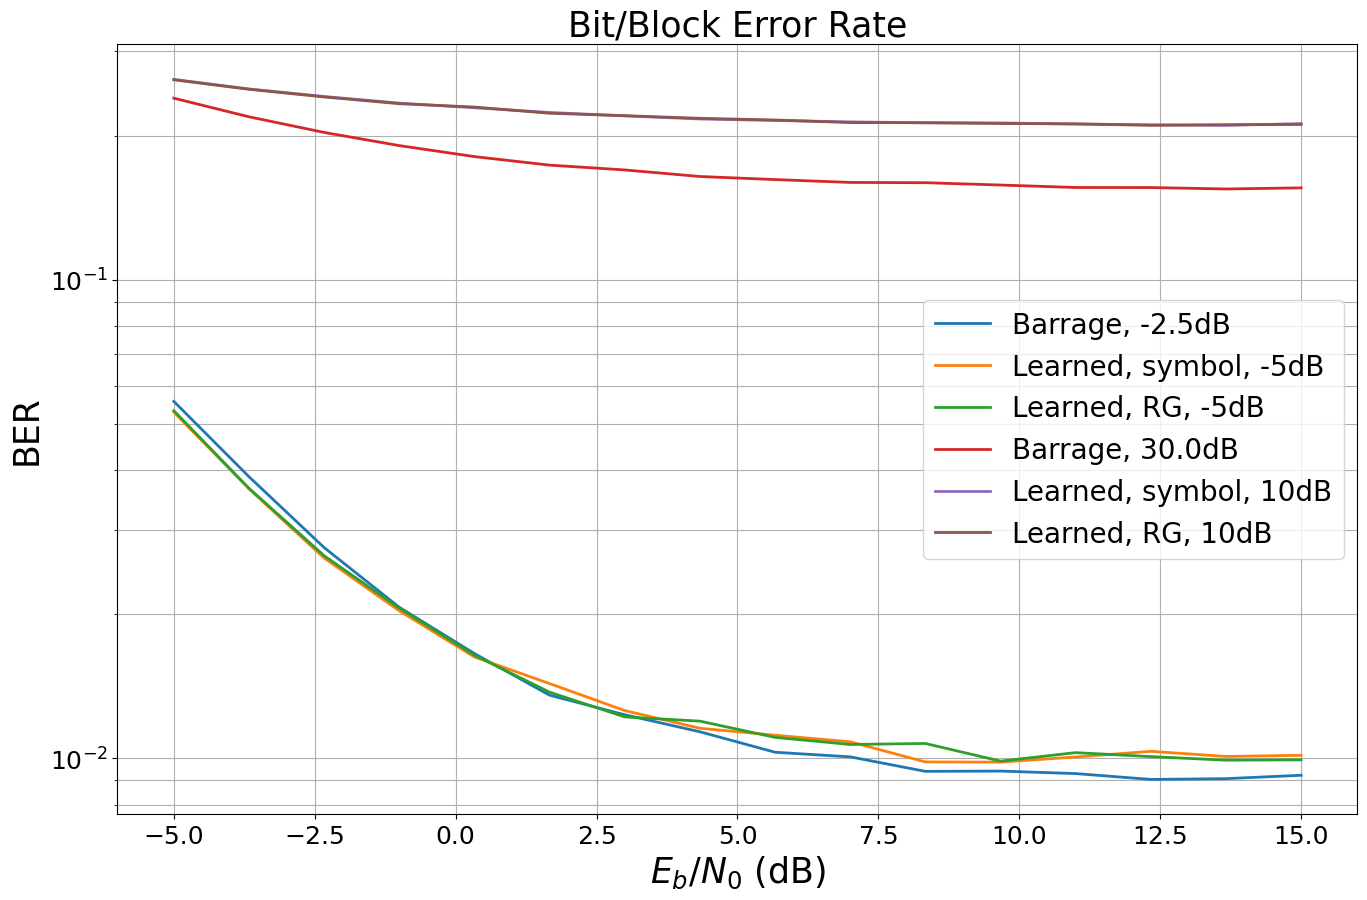

In [2]:
# symbol weights (old) vs. rg weights
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["jammer_present"] = True
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters

# TODO other file, change ebno_dbs
sim.BATCH_SIZE = 128
sim.MAX_MC_ITER = 5#0

ber_plots.reset()
jammer_powers_db = [-5, 10]
equivalent_jammer_powers = [-2.5, 30.0]
for jammer_power_db, equivalent in zip(jammer_powers_db, equivalent_jammer_powers):
    # barrage simulation
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(equivalent))
    simulate_model(model, f"Barrage, {equivalent}dB")
    # learned symbol weights
    jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(jammer_power_db))
    load_weights(model, f"weights/unmitigated/symbol/ue_4_pow_{jammer_power_db}dB.pickle")
    simulate_model(model, f"Learned, symbol, {jammer_power_db}dB")
    # learned rg weights
    jammer_parameters["trainable_mask"] = tf.ones([14, 128], dtype=tf.bool)
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(jammer_power_db))
    load_weights(model, f"weights/paper/unmitigated_rg_ue_4_pow_{jammer_power_db}dB.pickle")
    simulate_model(model, f"Learned, RG, {jammer_power_db}dB")

ber_plots()
# TODO save the plot 

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.7600e-02 | 5.2750e-01 |     1232061 |    32768000 |         3376 |        6400 |        33.5 |reached max iter       
   -2.778 | 1.1643e-02 | 1.9734e-01 |      381510 |    32768000 |         1263 |        6400 |        14.0 |reached max iter       
   -0.556 | 6.8445e-03 | 1.1188e-01 |      224281 |    32768000 |          716 |        6400 |        13.9 |reached max iter       
    1.667 | 5.1638e-03 | 8.3125e-02 |      169208 |    32768000 |          532 |        6400 |        13.7 |reached max iter       
    3.889 | 4.6047e-03 | 7.5313e-02 |      150887 |    32768000 |          482 |        6400 |        13.9 |reached max iter       
    6.111 | 4.4955e-03 | 7.3906e-02 |      147310 |    32768000 |          473 |     

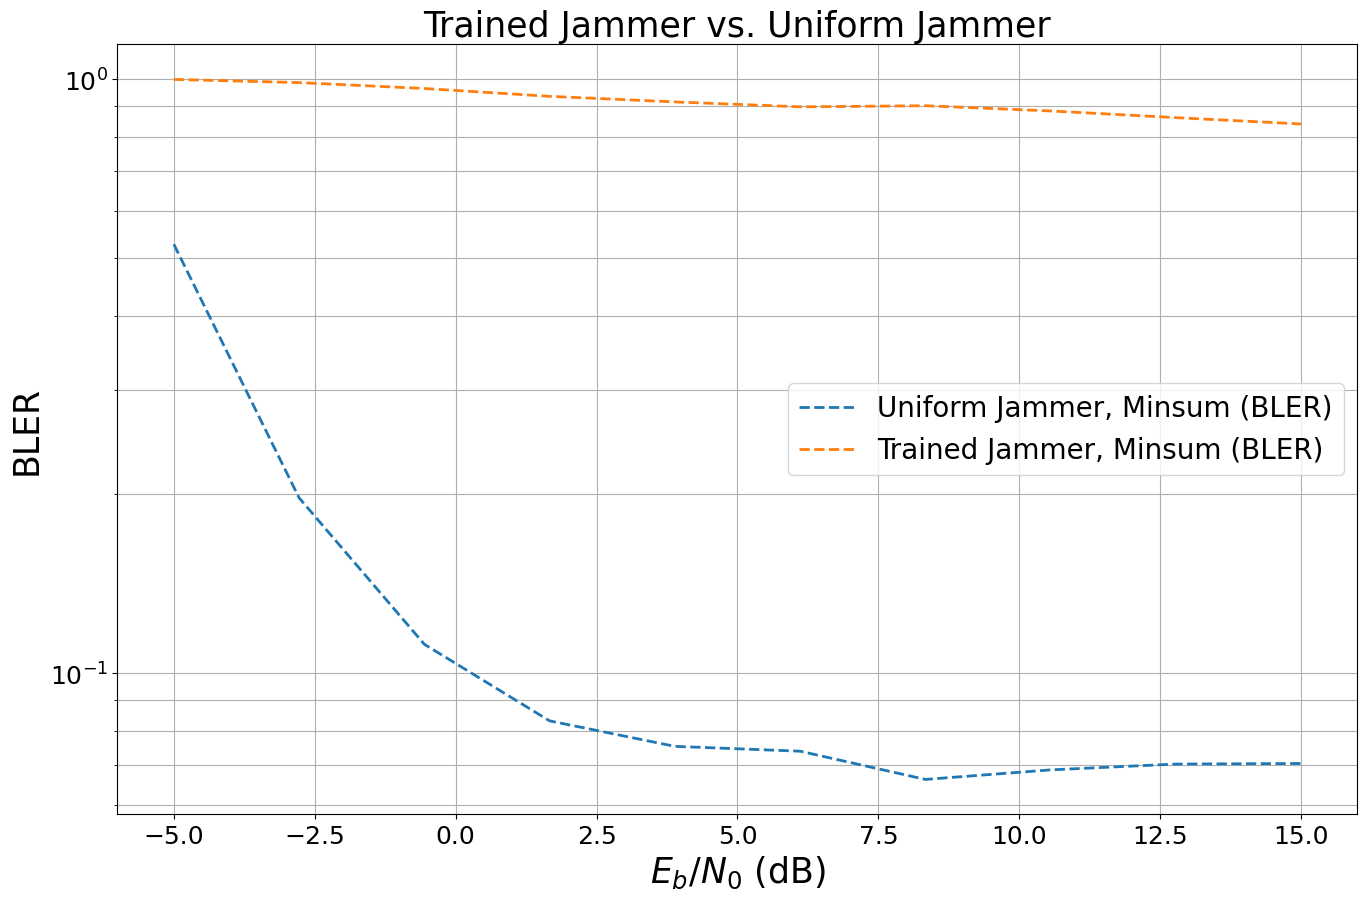

In [2]:
# noch einen Plot mit Minsum
ber_plots.reset()
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["num_ut"] = 4
model_parameters["jammer_present"] = True
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128], dtype=tf.bool)
decoder_parameters["num_iter"] = 20
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters
sim.BATCH_SIZE = 128
# sim.MAX_MC_ITER = 2000
# sim.ebno_dbs = np.linspace(-5., 15., 21)
# TODO change
sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)

# Uniform jammer with Minsum
decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
model._decoder.llr_max = 1000
simulate_model(model, "Uniform Jammer, Minsum", add_bler=True)

# Trained jammer
model = Model(**model_parameters)
model._decoder.llr_max = 1000
load_weights(model, f"weights/paper/ue_4_coded.pickle")
simulate_model(model, "Trained Jammer, Minsum", add_bler=True)

ber_plots.title = "Trained Jammer vs. Uniform Jammer"
ber_plots(show_ber=False)
# TODO save the plot
# with open("bers/paper/coded_bler.pickle", 'wb') as f:
#     bers = pickle.dump(ber_plots, f)